# Constant Definition

In [64]:
DATASET_PATH = "./dataset/"
RANDOM_SEED = 5508

# Dataset Import and Preprocess
In this section, we import data and preprocess them. First, we create a filter from labels dataframe. Then, we filter row in features and labels, and make a copy of then. Finally, we convert label to binary, 1 for Sandal and 0 for Sneaker.

In [65]:
import pandas as pd


def readCSV(filename: str):
    return pd.read_csv(DATASET_PATH + filename, header=None)


origin_train_set = readCSV("FMNIST_training_set.csv")
origin_train_set_labels = readCSV("FMNIST_training_set_labels.csv")
origin_test_set = readCSV("FMNIST_test_set.csv")
origin_test_set_labels = readCSV("FMNIST_test_set_labels.csv")


def preprocess_data(features: pd.DataFrame, labels: pd.DataFrame):
    filter = labels.iloc[:, 0].isin([5, 7])
    filtered_features = features[filter].copy()
    filtered_labels = labels[filter].copy()
    filtered_labels[filtered_labels == 5] = 1  # Sandal
    filtered_labels[filtered_labels == 7] = 0  # Sneaker
    return filtered_features, filtered_labels


train_X, train_y = preprocess_data(origin_train_set, origin_train_set_labels)
test_X, test_y = preprocess_data(origin_test_set, origin_test_set_labels)
# check first 5 rows of the training set
train_y_copy = train_y.copy().rename(columns={0: "label"})
pd.concat([train_y_copy, train_X], axis=1).iloc[:5, :25]

,label,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
12,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,53,102,144,169,149
41,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Summarising the datasets
## D1 [3 marks]: List number of instances
We use shape attribute to get the number of instances in the dataset. The shape attribute shows the number of rows and columns, which the first number is the number of rows.

In [66]:
pd.DataFrame(
    {
        "Number of instances": [
            train_X.shape[0],
            test_X.shape[0],
            train_X.shape[0] + test_X.shape[0],
        ]
    },
    index=["Train set", "Test set", "Total"],
)

,Number of instances
Train set,11988
Test set,2000
Total,13988


## D2 [2 marks]: Provide a bar plot showing the number of instances for each class label. Do you have an imbalanced training set?

We can see from the plot that, the numbers of two classed are balanced. So, we don't have an imbalanced training set.

<Axes: title={'center': 'Number of instances for eash class'}, xlabel='Categories'>

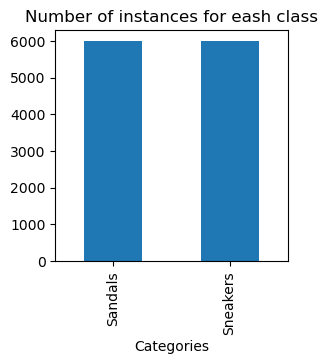

In [67]:
pd.DataFrame(
    {
        "Categories": ["Sandals", "Sneakers"],
        "Number": [
            train_y.value_counts()[1],
            train_y.value_counts()[0],
        ],
    }
).plot(
    x="Categories",
    y="Number",
    kind="bar",
    legend=False,
    title="Number of instances for eash class",
    figsize=(3, 3),
)

## D3 [3 marks]: Plot the first six images/examples from each class with the corresponding example id and associated label on the top of the plot.
First, we find the first six images of each class. Then we arrange the images so they can show in either left side or right side. Finally, we plot the images, where 1 is Sandal and 0 is Sneaker.


In [68]:
IMAGE_SHAPE = (28, 28)

sandals = []
for index, row in train_X[train_y.iloc[:, 0] == 1].iloc[:6].iterrows():
    sandals.append(
        {
            "index": index,
            "image": row.values.reshape(IMAGE_SHAPE),
            "label": 1,
        }
    )

sneakers = []
for index, row in train_X[train_y.iloc[:, 0] == 0].iloc[:6].iterrows():
    sneakers.append(
        {
            "index": index,
            "image": row.values.reshape(IMAGE_SHAPE),
            "label": 0,
        }
    )

images = []
for i in range(0, 12):
    if i % 4 < 2:
        images.append(sandals.pop(0))
    else:
        images.append(sneakers.pop(0))

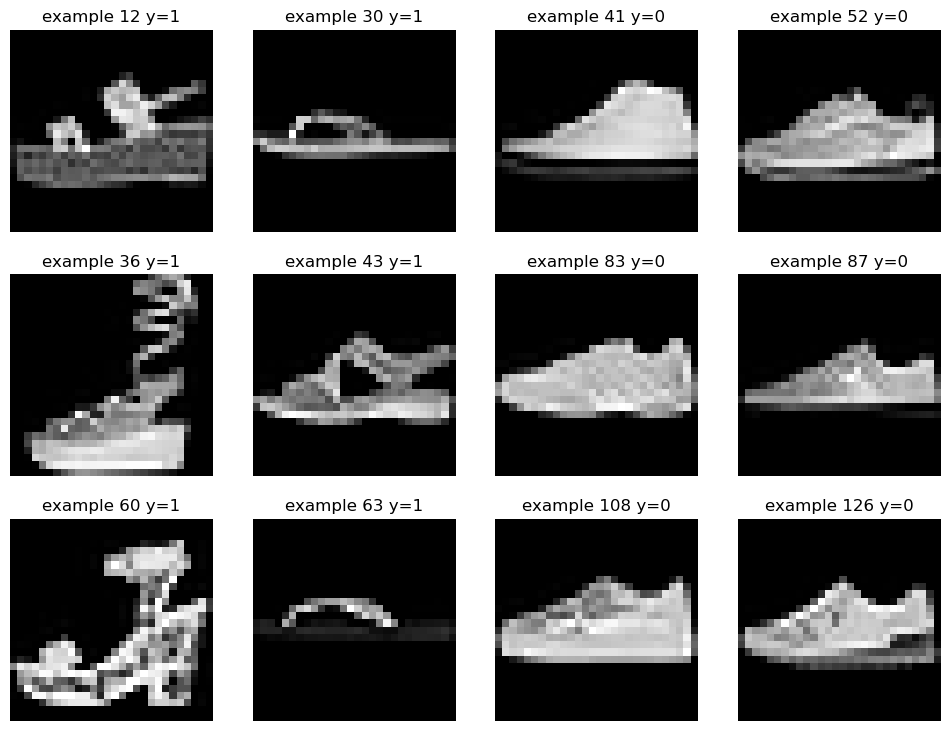

In [69]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))

axes = axes.flatten()

for i, image in enumerate(images):
    ax = axes[i]
    ax.imshow(image['image'], cmap='gray') 
    ax.set_title(f'example {image['index']} y={image['label']}')
    ax.axis('off')  # Turn off axis labels
 

# Fitting your logistic regression classifier
## Dataset Splitting
Firstly, we further split the training dataset into training and validation set by generating a random array of a uniform distribution between 0 and 1. We check the length of output to make sure the split is correct.

In [70]:
import numpy as np

origin_X, origin_y = preprocess_data(origin_train_set, origin_train_set_labels)
origin_X = origin_X.values
origin_y = origin_y.values.flatten()

selected_filters = np.random.RandomState(RANDOM_SEED).rand(origin_X.shape[0]) < 0.8

train_X = origin_X[selected_filters]
valid_X = origin_X[~selected_filters]
train_y = origin_y[selected_filters]
valid_y = origin_y[~selected_filters]

print(f"Train set: {train_X.shape[0]} instances")
print(f"Validation set: {valid_X.shape[0]} instances")
print(f"Test set: {test_X.shape[0]} instances")

Train set: 9625 instances
Validation set: 2363 instances
Test set: 2000 instances


## Model Implementation
For this binary classification problem, we use logistic regression method. Refer to assignment instruction and Hands-on-Machine-Learning page 240, we obtain the following formula for logistic regression:

\begin{align}
&\text{Sigmoid function:}&&\sigma(x) = \frac{1}{1+e^{-x}} \\
&\text{Prediction:}&&\hat{y} = \sigma(Xw) \\
&\text{Cost function:}&&L = -mean(y*\log(\hat{y}) + (1-y)*\log(1-\hat{y})) \\
&\text{Gardient:}&&G=\frac{\delta L}{\delta w} = \frac{X^{T}(\hat{y}-y)}{length(X)} \\
\end{align}

Where $X$ is the augmented feature matrix, $w$ is the parameter vector or to call it theta, $y$ is the label vector, and $\hat{y}$ is the prediction vector.

We use pytorch to implement the logistic regression from scratch so we can use GPU to speed up the computation. In fit method you can see the process of each epoch. Firstly, we calculate gradients. Then, we update the parameter $w$ by subtrating $\eta*G$ where $\eta$ is the learning rate. To avoid -inf in log, we add a small number $\epsilon$ in the input. Finally, we log the cost and misclassification rate of the training and validation set.

In [71]:
import torch

if torch.cuda.is_available():
    # Set the default tensor type to be a CUDA tensor
    torch.set_default_device(torch.device("cuda"))


class Classification:
    def __init__(
        self,
        train_X,
        train_y,
        valid_X,
        valid_y,
        eta=1e-5,
        epochs=10000,
        threshold=0.5,
        record_interval=100,
    ) -> None:
        # self.w = torch.rand(train_X.shape[1] + 1, 1)
        self.w = torch.zeros(train_X.shape[1] + 1, 1)
        self.train_X_b = torch.cat(
            (torch.tensor(train_X), torch.ones(train_X.shape[0], 1)), dim=1
        )
        self.valid_X_b = torch.cat(
            (torch.tensor(valid_X), torch.ones(valid_X.shape[0], 1)), dim=1
        )
        self.train_y = torch.tensor(train_y).reshape(-1, 1)
        self.valid_y = torch.tensor(valid_y).reshape(-1, 1)
        self.threshold = threshold
        self.eta = eta
        self.epochs = epochs
        self.record_interval = record_interval
        self.log_init()
        pass

    def predict(self, X):
        logistic_fn = lambda x: 1 / (1 + torch.exp(-x))
        return logistic_fn(X @ self.w)

    def cost(self, y, hat_y):
        epsilon = 1e-8
        return -torch.mean(
            y * torch.log(hat_y + epsilon) + (1 - y) * torch.log(1 - hat_y + epsilon)
        )

    def mis_rate(self, y, hat_y, threshold=None):
        threshold = threshold or self.threshold
        return torch.mean(((hat_y > threshold) != y.bool()).float())

    def calc_gradients(self, X, y, hat_y):
        return (X.t() @ (hat_y - y)) / X.shape[0]

    def update(self):
        train_pred_y = self.predict(self.train_X_b)
        gradients = self.calc_gradients(self.train_X_b, self.train_y, train_pred_y)
        self.w -= self.eta * gradients

    def fit(self):
        for epoch in range(self.epochs):
            self.update()
            if epoch % self.record_interval == 0:
                self.log(epoch)

    def log_init(self):
        self.epoch_list = []
        self.train_cost_list = []
        self.valid_cost_list = []
        self.train_mis_rate_list = []
        self.valid_mis_rate_list = []

    def log(self, epoch):
        self.epoch_list.append(epoch)
        train_pred_y = self.predict(self.train_X_b)
        train_cost = self.cost(self.train_y, train_pred_y)
        self.train_cost_list.append(train_cost.to("cpu"))
        valid_pred_y = self.predict(self.valid_X_b)
        valid_cost = self.cost(self.valid_y, valid_pred_y)
        self.valid_cost_list.append(valid_cost.to("cpu"))
        train_mis_rate = self.mis_rate(self.train_y, train_pred_y)
        self.train_mis_rate_list.append(train_mis_rate.to("cpu"))
        valid_mis_rate = self.mis_rate(self.valid_y, valid_pred_y)
        self.valid_mis_rate_list.append(valid_mis_rate.to("cpu"))

## D4 [3 marks]: Experiment on different $\eta$

We experiment with six different learning rates and plot the cost curve of the training.

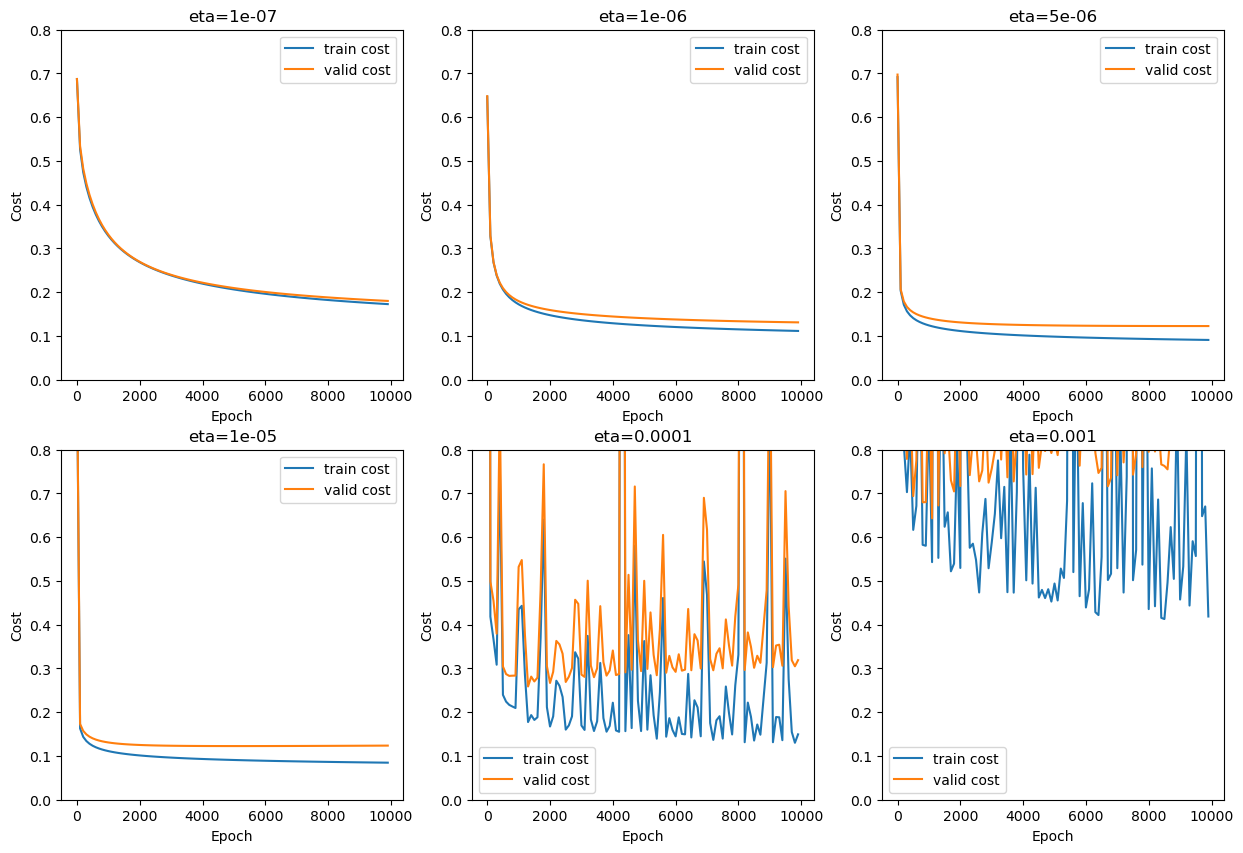

In [74]:
import matplotlib.pyplot as plt

etas = [1e-7, 1e-6, 5e-6, 1e-5, 1e-4, 1e-3]
# etas = [ 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    clf = Classification(train_X, train_y, valid_X, valid_y, eta=etas[i])
    clf.fit()
    ax.plot(clf.epoch_list, clf.train_cost_list, label="train cost")
    ax.plot(clf.epoch_list, clf.valid_cost_list, label="valid cost")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Cost")
    ax.set_title(f"eta={etas[i]}")
    ax.set_ylim(0, 0.8)
    ax.legend()

From the result we can see that, when epochs is 10000, best learning rate is around 1e6. When learning rate is higher than 1e6, the train cost and validation cost curve start to diverge, which means the model is overfitting. When learning rate is lower than 1e6, the model is underfitting. Or maybe we can use a smaller learning rate and more epochs to get a better result.

## D5 [10 marks]: Cost and Misclassification Error when $\eta = 10^{-5}$

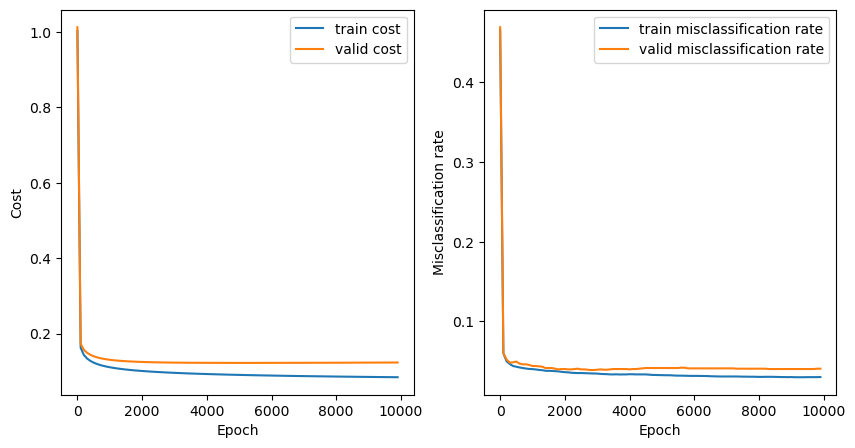

In [75]:
clf = Classification(train_X, train_y, valid_X, valid_y, eta=1e-5)
clf.fit()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.plot(clf.epoch_list, clf.train_cost_list, label="train cost")
ax1.plot(clf.epoch_list, clf.valid_cost_list, label="valid cost")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Cost")
ax1.legend()
ax2.plot(clf.epoch_list, clf.train_mis_rate_list, label="train misclassification rate")
ax2.plot(clf.epoch_list, clf.valid_mis_rate_list, label="valid misclassification rate")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Misclassification rate")
ax2.legend()

## D6 [3 marks]: Explain the result

From the result we can see that, as the training goes on, the cost and misclassification error of train set is both decreasing. However, the cost and misclassification error of validation set isn't decreasing after around 2000 epochs. This is because the model is overfitting. That may be caused by too complex model. Or we can use early stopping to avoid overfitting.

# 4.3 Using cross-validation and Scikit-learn logistic regression classifier
Now we improve our model and add a L2 regularization term to the cost function. The new cost function is:

\begin{align}
&\text{Cost function:}&&L = -mean(y*\log(\hat{y}) + (1-y)*\log(1-\hat{y})) +  w^2 / C  \\
&\text{Gardient:}&&G=\frac{\delta L}{\delta w} = \frac{X^{T}(\hat{y}-y)}{length(X)} + 2w / C \\
\end{align}

## D7 [6 marks]: Experiment on different C

In [88]:
class RegulizedClassification(Classification):
    def __init__(
        self,
        *args,
        C=1,
        **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)
        self.C = C

    def regulized_cost(self, y, hat_y):
        epsilon = 1e-8
        return -torch.mean(
            y * torch.log(hat_y + epsilon) + (1 - y) * torch.log(1 - hat_y + epsilon)
        ) + 2 / self.C * torch.sum(self.w**2)

    def calc_gradients(self, X, y, hat_y):
        return (X.t() @ (hat_y - y)) / X.shape[0] + 2 / self.C * self.w

    def log(self, epoch):
        self.epoch_list.append(epoch)
        train_pred_y = self.predict(self.train_X_b)
        train_cost = self.regulized_cost(self.train_y, train_pred_y)
        self.train_cost_list.append(train_cost.to("cpu"))
        valid_pred_y = self.predict(self.valid_X_b)
        valid_cost = self.cost(self.valid_y, valid_pred_y)
        self.valid_cost_list.append(valid_cost.to("cpu"))
        train_mis_rate = self.mis_rate(self.train_y, train_pred_y)
        self.train_mis_rate_list.append(train_mis_rate.to("cpu"))
        valid_mis_rate = self.mis_rate(self.valid_y, valid_pred_y)
        self.valid_mis_rate_list.append(valid_mis_rate.to("cpu"))

In [89]:
import numpy as np

C_range = np.logspace(-10, 5, 30)

C_train_cost_list = []
C_valid_cost_list = []
C_train_mis_rate_list = []
C_valid_mis_rate_list = []

for C in C_range:
    clf = RegulizedClassification(train_X, train_y, valid_X, valid_y, C=C, eta=1e-5)
    clf.fit()
    C_train_cost_list.append(clf.train_cost_list[-1])
    C_valid_cost_list.append(clf.valid_cost_list[-1])
    C_train_mis_rate_list.append(clf.train_mis_rate_list[-1])
    C_valid_mis_rate_list.append(clf.valid_mis_rate_list[-1])

Text(0.5, 1.0, 'Misclassification rate vs C')

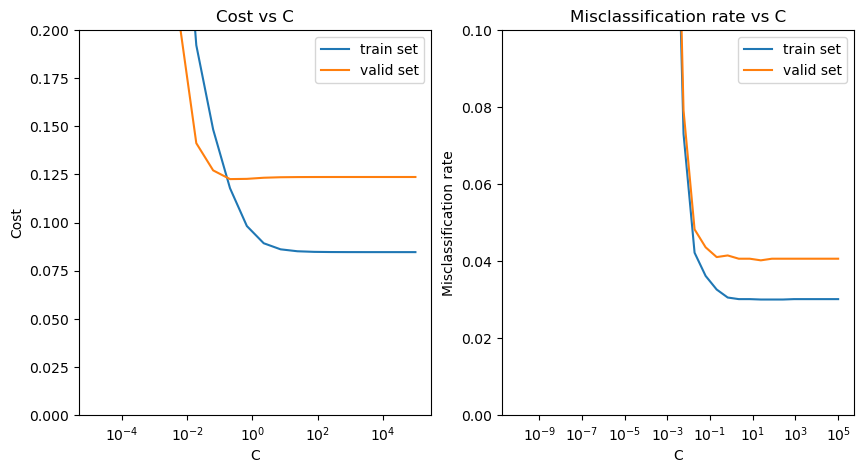

In [109]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.plot(C_range, C_train_cost_list, label="train set")
ax1.plot(C_range, C_valid_cost_list, label="valid set")
ax1.set_xlabel("C")
ax1.set_xscale("log")
ax1.set_ylabel("Cost")
ax1.legend()
ax1.set_ylim(0, 0.2)
ax1.set_title("Cost vs C")
ax2.plot(C_range, C_train_mis_rate_list, label="train set")
ax2.plot(C_range, C_valid_mis_rate_list, label="valid set")
ax2.set_xlabel("C")
ax2.set_xscale("log")
ax2.set_ylabel("Misclassification rate")
ax2.legend()
ax2.set_ylim(0, 0.1)
ax2.set_title("Misclassification rate vs C")


From the result we can see that, as C increase, the model is more likely to overfit. When C is around 0.1, the model get the best result on validation set.

## D8 [4 marks]: Find the best C with LogisticRegressionCV
In this section, we explore the best C using LogisticRegressionCV with the same range. After fitting the model, the best C that we get is 0.18. Two plots are provided to show how the cost and misclassification error change with C. To accelerate the training, we scale the features.

In [141]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
origin_X_scaled = scaler.fit_transform(origin_X)

lr = LogisticRegressionCV(
    cv=10,
    Cs=C_range,
    scoring="neg_log_loss",
    max_iter=10000,
    random_state=RANDOM_SEED,
)

lr.fit(origin_X_scaled, origin_y)

cost_list = -np.mean(lr.scores_[1], axis=0)

lr = LogisticRegressionCV(
    cv=10,
    Cs=C_range,
    scoring="accuracy",
    max_iter=10000,
    random_state=RANDOM_SEED,
)

lr.fit(origin_X_scaled, origin_y)

mis_rate_list = 1 - np.mean(lr.scores_[1], axis=0)

lr.C_ # best C

array([0.01887392])

(0.0, 0.2)

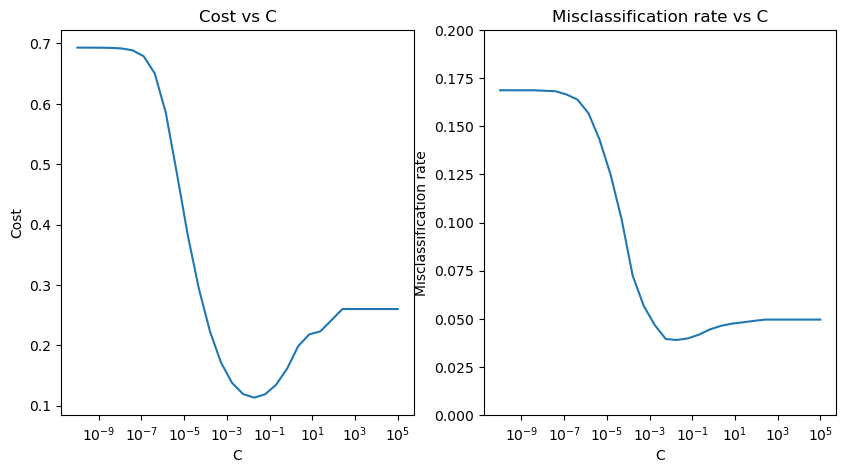

In [135]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.plot(C_range, cost_list)
ax1.set_xlabel("C")
ax1.set_xscale("log")
ax1.set_ylabel("Cost")
ax1.set_title("Cost vs C")
# ax1.set_ylim(0, 0.3)
ax2.plot(C_range, mis_rate_list)
ax2.set_xlabel("C")
ax2.set_xscale("log")
ax2.set_ylabel("Misclassification rate")
ax2.set_title("Misclassification rate vs C")
ax2.set_ylim(0, 0.2)

## D9 [3 marks]: Interpret the result
From the training result we can know, the best C is 0.0189. From the plot we can see that, when C is around 0.01, both the cost and misclassification error of validation set is the lowest. Which means the model reach a banlaned point between overfitting and underfitting. 
After using 10-fold cross-validation, the bias of spliting dataset is reduced. So, the result model is more reliable.

## D10 [5 marks]: Find the best C with SGDClassifier and GridSearchCV 

In [147]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier


param_grid = {
    "alpha": [1 / c for c in C_range],
}

sgd = SGDClassifier(
    loss="log_loss", random_state=RANDOM_SEED, learning_rate="constant", eta0=1e-5
)
grid_search = GridSearchCV(sgd, param_grid, scoring="neg_log_loss")
grid_search.fit(train_X, train_y)

GridSearchCV(estimator=SGDClassifier(eta0=1e-05, learning_rate='constant',
                                     loss='log_loss', random_state=5508),
             param_grid={'alpha': [10000000000.0, 3039195382.3131948,
                                   923670857.1873846, 280721620.394117,
                                   85316785.24172814, 25929437.97404667,
                                   7880462.8156699035, 2395026.6199874813,
                                   727895.3843983146, 221221.6291070446,
                                   67233.57536499335, 20433.597178569395,
                                   6210.1..., 1887.391822135096,
                                   573.615251044867, 174.33288221999874,
                                   52.98316906283702, 16.10262027560936,
                                   4.893900918477479, 1.4873521072935119,
                                   0.4520353656360241, 0.13738237958832608,
                                   0.04175318936560392, 0.012689610031679182,
                                   0.0038566204211634564, 0.0011721022975334794,
                                   0.0003562247890262437, 0.0001082636733874052,
                                   3.2903445623126575e-05, 1e-05]},
             scoring='neg_log_loss')

In [149]:
from sklearn.metrics import accuracy_score

best_sgd = grid_search.best_estimator_

table = {
    "Optimal C": 1 / grid_search.best_params_["alpha"],
    "Train Cost": log_loss(train_y, best_sgd.predict_proba(train_X)),
    "Valid Cost": log_loss(valid_y, best_sgd.predict_proba(valid_X)),
    "Train Misclassification rate": 1
    - accuracy_score(train_y, best_sgd.predict(train_X)),
    "Valid Misclassification rate": 1
    - accuracy_score(valid_y, best_sgd.predict(valid_X)),
}

pd.DataFrame(table, index=["Value"])

,Optimal C,Train Cost,Valid Cost,Train Misclassification rate,Valid Misclassification rate
Value,0.062102,1.542815,1.725842,0.108156,0.115954


## D11 [3 marks]: Give a short interpretation of your results.

The optimal C we obtain here is 0.062, which is slightly higher than the C we obtained from LogisticRegressionCV. This may means that for sthchasitc gradient descent, lighter regularization is needed to reach the best result.

## D12 [5 marks]: With the obtained C, train your model using the training set.

In [151]:
clf = RegulizedClassification(train_X, train_y, valid_X, valid_y, C=0.062, eta=1e-5)
clf.fit()

(0.5, 1.0)

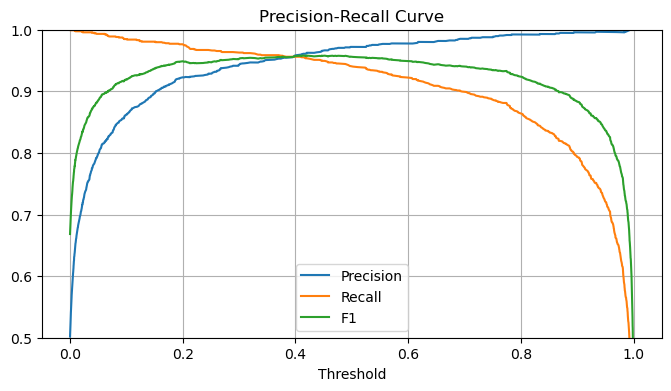

In [165]:
from sklearn.metrics import precision_recall_curve

valid_y_hat = clf.predict(clf.valid_X_b)
precisions, recalls, thresholds = precision_recall_curve(
    clf.valid_y.cpu(), valid_y_hat.cpu()
)
f1 = 2 * precisions * recalls / (precisions + recalls)
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, f1[:-1], label="F1")
plt.xlabel("Threshold")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.ylim(0.5, 1)

We can see on the plot that, as threshold increase, precision increase and recall decrease. Note that, two curves across at threshold 0.38, after adding F1 score, we can see F1 score also seems to reach the highest at threshold 0.38. So, we choose 0.38 as the best threshold.

## D13 [4 marks]: Use a grid search (you may need to implement your own) to fine-tune the optimal threshold value using the validation set.

Since threshold is not present in cost function, it won't affect the training process. So, we can use model from last section, and perfrom grid search on threshold to find the best f1 score. After searching, we find the best threshold is 0.41. That means, we can't just choose a best threshold by eyes, but need to use grid search to find the best threshold.

In [183]:
valid_y_hat = clf.predict(clf.valid_X_b)
thresholds = np.linspace(0, 1, 1000)
f1_scores = []
for threshold in thresholds:
    tp = torch.sum((valid_y_hat > threshold) & (clf.valid_y == 1)).cpu()
    fp = torch.sum((valid_y_hat > threshold) & (clf.valid_y == 0)).cpu()
    fn = torch.sum((valid_y_hat <= threshold) & (clf.valid_y == 1)).cpu()
    precision = tp / (tp + fp + 1e-16)
    recall = tp / (tp + fn)
    f1_scores.append(2 * precision * recall / (precision + recall + 1e-16))

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold: {best_threshold}")

Best threshold: 0.4114114114114114


# 4.4 Analysing the performance closer
## D14 [8 marks]: Provide the model’s performance on the test set. For each LR1, LR2, LR3 and LR4,provide: The confusion matrix, Precision, recall, false positive rate

In [228]:
# Model preparation
lr1 = Classification(train_X, train_y, valid_X, valid_y, eta=1e-5)
lr2 = RegulizedClassification(train_X, train_y, valid_X, valid_y, C=0.062, eta=1e-5)
lr3 = LogisticRegressionCV(
    cv=10,
    Cs=[0.062],
    scoring="neg_log_loss",
    max_iter=10000,
    random_state=RANDOM_SEED,
)
lr4 = lr3
# lr4 is same to lr3 only with different thereshold
lr1.fit()
lr2.fit()
lr3.fit(origin_X_scaled, origin_y)

LogisticRegressionCV(Cs=[0.062], cv=10, max_iter=10000, random_state=5508,
                     scoring='neg_log_loss')

In [211]:
# Data preparation
test_X, test_y = preprocess_data(origin_test_set, origin_test_set_labels)
test_X = test_X.values
test_X_scaled = scaler.transform(test_X)
test_y = test_y.values.flatten()


def performance(y_hat, y, threshold):
    tp = np.sum((y_hat > threshold) & (y == 1))
    fp = np.sum((y_hat > threshold) & (y == 0))
    fn = np.sum((y_hat <= threshold) & (y == 1))
    tn = np.sum((y_hat <= threshold) & (y == 0))

    confusion_matrix = pd.DataFrame(
        [[tp, fp], [fn, tn]],
        columns=["Actual Positive", "Actual Negative"],
        index=["Predicted Positive", "Predicted Negative"],
    )

    print(confusion_matrix)
    precision = tp / (tp + fp + 1e-16)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall + 1e-16)
    print("\n")
    print(
        pd.DataFrame(
            {
                "False Positive Rate": fp / (fp + tn + 1e-16),
                "Precision": precision,
                "Recall": recall,
                "F1": f1,
            },
            index=["Value"],
        )
    )

### LR1

In [212]:
test_X_b = torch.cat((torch.tensor(test_X), torch.ones(test_X.shape[0], 1)), dim=1)

test_y_hat = lr1.predict(test_X_b)
performance(test_y_hat.cpu().numpy().reshape(-1), test_y, 0.5)

                    Actual Positive  Actual Negative
Predicted Positive              941               38
Predicted Negative               59              962


       False Positive Rate  Precision  Recall        F1
Value                0.038   0.961185   0.941  0.950985


### LR2

In [213]:
test_y_hat = lr2.predict(test_X_b)
performance(test_y_hat.cpu().numpy().reshape(-1), test_y, 0.5)

                    Actual Positive  Actual Negative
Predicted Positive              936               31
Predicted Negative               64              969


       False Positive Rate  Precision  Recall        F1
Value                0.031   0.967942   0.936  0.951703


### LR3

In [215]:
test_y_hat = lr3.predict_proba(test_X_scaled)[:, 1]
performance(test_y_hat, test_y, 0.5)

                    Actual Positive  Actual Negative
Predicted Positive              956               36
Predicted Negative               44              964


       False Positive Rate  Precision  Recall        F1
Value                0.036    0.96371   0.956  0.959839


### LR4

In [216]:
test_y_hat = lr3.predict_proba(test_X_scaled)[:, 1]
performance(test_y_hat, test_y, 0.41)

                    Actual Positive  Actual Negative
Predicted Positive              963               43
Predicted Negative               37              957


       False Positive Rate  Precision  Recall       F1
Value                0.043   0.957256   0.963  0.96012


## D15 [3 marks]: Briefly comment on the results you see. Discuss the generalisation capacity of the four models.

Using F1 score as our judging criteria, we can see that, as we improve the model, the F1 scrore is higher and higher, LR1 < LR2 < LR3 < LR4. So, the generalisation capacity of the four models is LR4 > LR3 > LR2 > LR1. That means, by applying regularization, k-fold cross-validation, and threshold tuning, we can improve the generalisation capacity of the model.

## D16 [4 marks]: Consider the model LR4 and show five images that are false positives on the test set and five images that are false negatives.

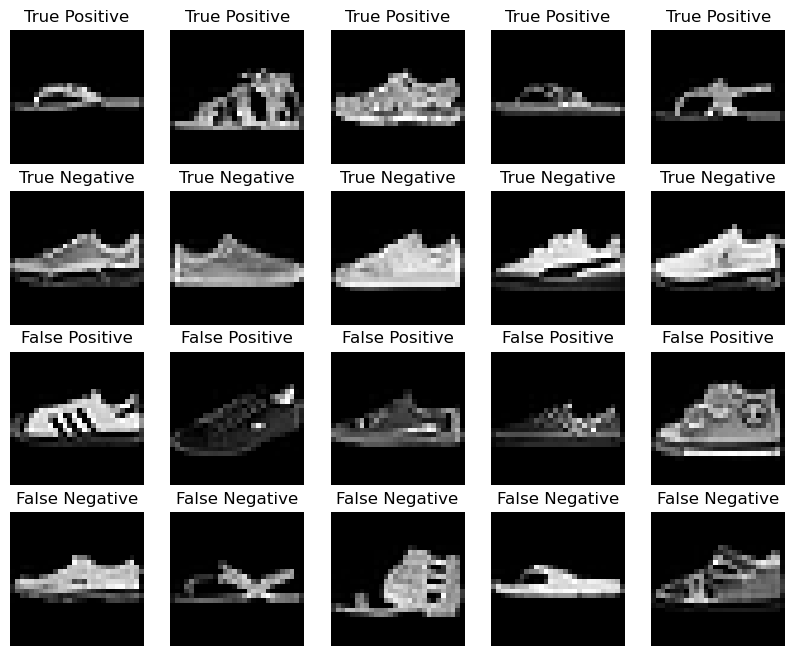

In [227]:
test_y_hat = lr4.predict_proba(test_X_scaled)[:, 1] > 0.41
true_positives = [
    test_X[i].reshape(IMAGE_SHAPE)
    for i in np.argwhere((test_y_hat == test_y) & (test_y == 1))[:5]
]

true_negatives = [
    test_X[i].reshape(IMAGE_SHAPE)
    for i in np.argwhere((test_y_hat == test_y) & (test_y == 0))[:5]
]

false_positives = [
    test_X[i].reshape(IMAGE_SHAPE)
    for i in np.argwhere((test_y_hat != test_y) & (test_y == 0))[:5]
]

false_negatives = [
    test_X[i].reshape(IMAGE_SHAPE)
    for i in np.argwhere((test_y_hat != test_y) & (test_y == 1))[:5]
]
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < 5:
        ax.imshow(true_positives[i], cmap="gray")
        ax.set_title("True Positive")
    elif i < 10:
        ax.imshow(true_negatives[i - 5], cmap="gray")
        ax.set_title("True Negative")
    elif i < 15:
        ax.imshow(false_positives[i - 10], cmap="gray")
        ax.set_title("False Positive")
    else:
        ax.imshow(false_negatives[i - 15], cmap="gray")
        ax.set_title("False Negative")
    ax.axis("off")

## D17 [2 marks]: Briefly comment on the results. Can you describe what kinds of mistakes the model is making?

From the images example we can see that, the model tends to judge images with more bright pixels as Sneaker and images with more dark pixels as Sandal. It seems that the model is not smart enough to distinguish images by their shape, but by their color. So, the model is making mistakes on images with similar color.

## D18 [2 marks]: Interpret the weights of the model LR4

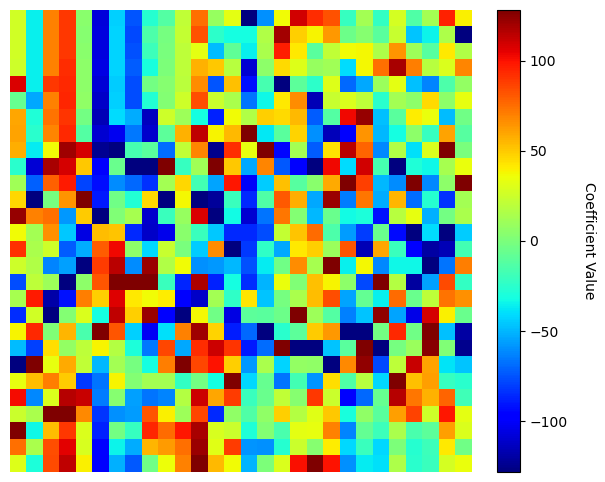

In [255]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-128, 128))
scaled_coef = scaler.fit_transform(lr4.coef_.reshape(28,28))

fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(scaled_coef, cmap='jet')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Coefficient Value', rotation=270, labelpad=20)
ax.axis('off')
plt.show()

## D19 [3 marks]: Inspect the values and magnitude of the weights.

We can see that, as what we guess in D17, there are many deep blue pixels in the center of the image and blue pixles means negative value in the weight. So, the model is more likely to judge images with bright pixels in the center as negative class, which is Sneaker.